In [2]:
import sys
import os

# 获取当前 Notebook 的路径
current_dir = os.path.dirname(os.path.abspath("__file__"))

# 获取上一级目录和上上一级目录
parent_dir = os.path.dirname(current_dir)
parent_parent_dir = os.path.dirname(parent_dir)

# 添加上一级目录和上上一级目录到 sys.path 中
sys.path.append(parent_dir)
sys.path.append(parent_parent_dir)

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LogNorm
import joblib

from utils import read_jsonl

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer
from eap.graph import Graph
from analyzer import ComponentAnalyzer
from analyzer import draw_rank_logits, draw_attention_pattern, draw_output_pattern_with_text

In [5]:
model = "gpt2-medium"

In [6]:
target_token_rank_at_last = joblib.load("target_token_rank_at_last.pkl")
target_token_prob = joblib.load("target_token_prob.pkl")
target_token_rank_at_subject = joblib.load("target_token_rank_at_subject.pkl")

In [7]:
k_type = {
    "new": "compl",
    "revised": "rel"
}

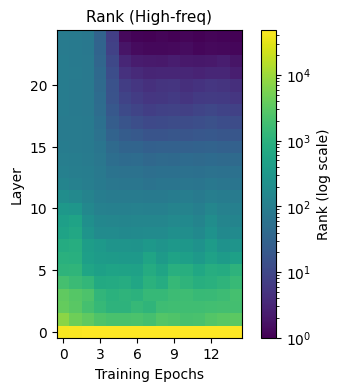

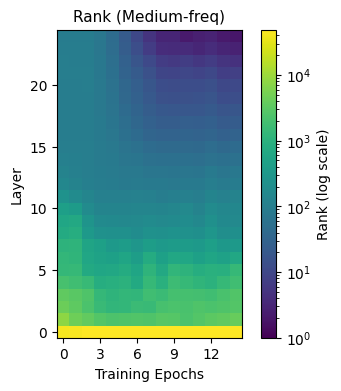

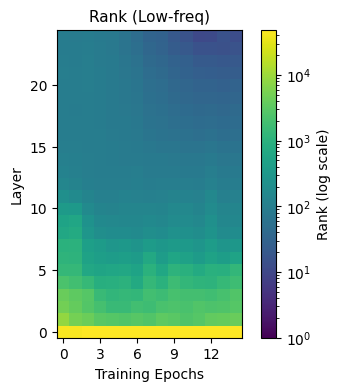

In [16]:
task = "city"
type = "new"
for freq in ["high", "medium", "low"]:
    target_token_rank_at_last_matrix = []
    for item in target_token_rank_at_last[task][type][freq]:
        target_token_rank_at_last_matrix.append(item)
    target_token_rank_at_last_matrix = np.array(target_token_rank_at_last_matrix)
    # Set the figure size to increase x-axis width
    plt.figure(figsize=(5,4))  # Adjust width and height as needed

    im = plt.imshow(target_token_rank_at_last_matrix.T, interpolation='nearest', norm=LogNorm(vmin=1, vmax=target_token_rank_at_last_matrix.max()))
    plt.title(f'Rank ({freq.capitalize()}-freq)', fontsize=11)
    plt.ylabel('Layer')
    plt.xlabel('Training Epochs')
    plt.colorbar().set_label('Rank (log scale)')
    # 反转 y 轴
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(0, 25, 5))
    plt.xticks(np.arange(0, target_token_rank_at_last_matrix.shape[0], 3))
    plt.show()

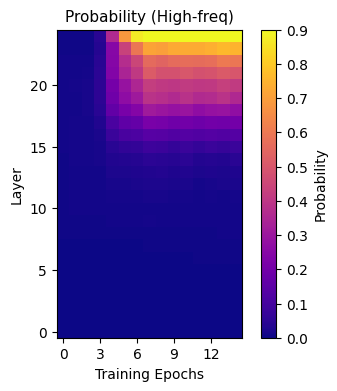

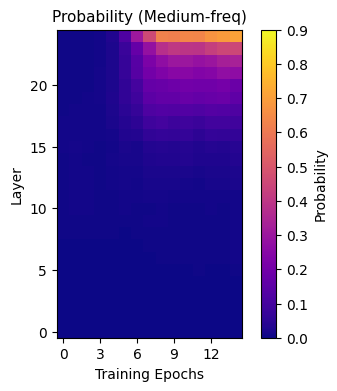

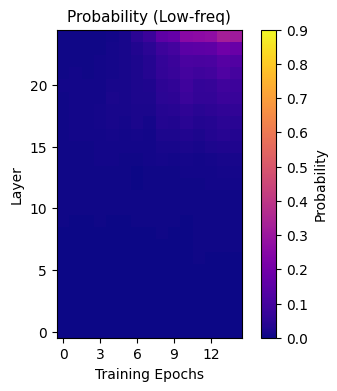

In [21]:
task = "city"
type = "new"
for freq in ["high", "medium", "low"]:
    target_token_prob_matrix = []
    for item in target_token_prob[task][type][freq]:
        target_token_prob_matrix.append(item)
    target_token_prob_matrix = np.array(target_token_prob_matrix)
    # Set the figure size to increase x-axis width
    plt.figure(figsize=(5,4))  # Adjust width and height as needed

    im = plt.imshow(target_token_prob_matrix.T, cmap='plasma', interpolation='nearest', vmin=0, vmax=0.9)
    plt.title(f'Probability ({freq.capitalize()}-freq)', fontsize=11)
    plt.ylabel('Layer')
    plt.xlabel('Training Epochs')
    plt.colorbar().set_label('Probability')
    # 反转 y 轴
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(0, 25, 5))
    plt.xticks(np.arange(0, target_token_rank_at_last_matrix.shape[0], 3))
    plt.show()

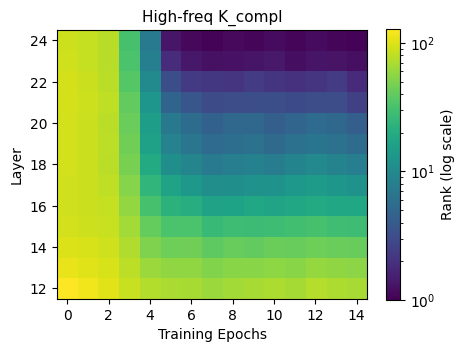

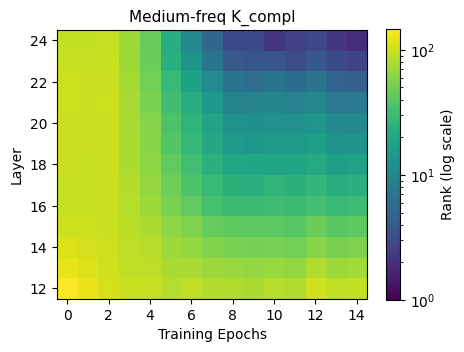

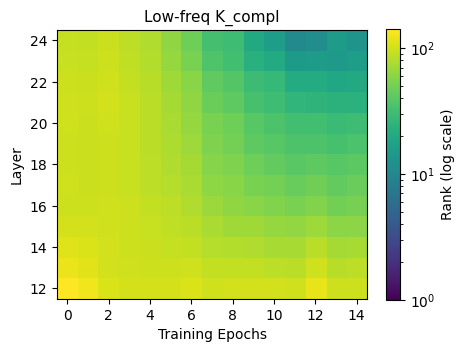

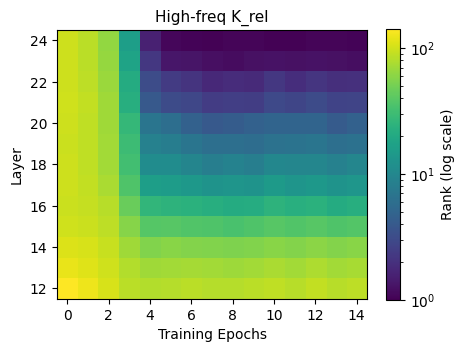

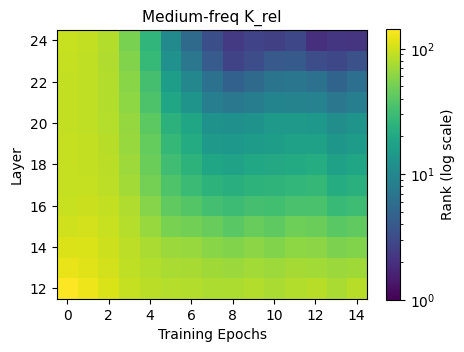

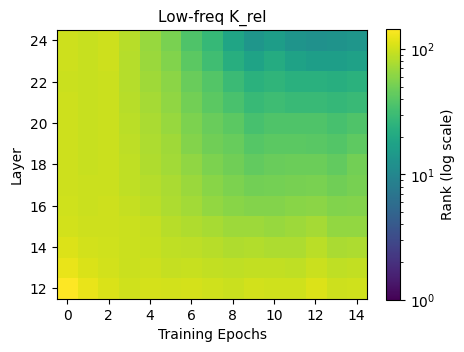

In [8]:
task = "city"
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        target_token_rank_at_last_matrix = []
        for item in target_token_rank_at_last[task][type][freq]:
            target_token_rank_at_last_matrix.append(item)
        target_token_rank_at_last_matrix = np.array(target_token_rank_at_last_matrix)

        half_index = target_token_rank_at_last_matrix.shape[1] // 2
        target_token_rank_at_last_matrix_half = target_token_rank_at_last_matrix[:, half_index:]

        # Set the figure size to increase x-axis width
        plt.figure(figsize=(5, 4))  # Adjust width and height as needed

        im = plt.imshow(
            target_token_rank_at_last_matrix_half.T,
            interpolation='nearest',
            norm=LogNorm(
                vmin=1,
                vmax=target_token_rank_at_last_matrix_half.max()
            )
        )
        plt.title(f'{freq.capitalize()}-freq K_{k_type[type]}', fontsize=11)
        plt.ylabel('Layer')
        plt.xlabel('Training Epochs')
        plt.colorbar(shrink=0.88).set_label('Rank (log scale)')
        # 反转 y 轴
        plt.gca().invert_yaxis()

        # 调整 yticks，仅显示后一半对应的范围
        num_layers = target_token_rank_at_last_matrix_half.shape[1]
        plt.yticks(
            np.arange(0, num_layers, 2),  # 每隔2个单位标一个刻度
            labels=np.arange(half_index, half_index + num_layers, 2)  # 标签对应原来的 layer 数值
        )
        plt.xticks(np.arange(0, target_token_rank_at_last_matrix_half.shape[0], 2))
        plt.show()

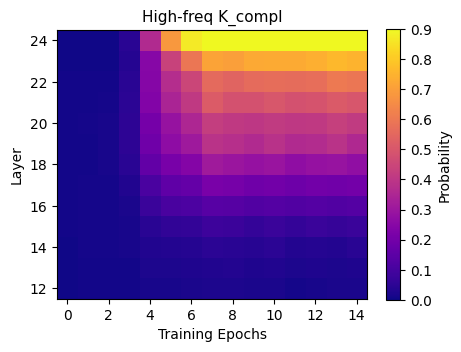

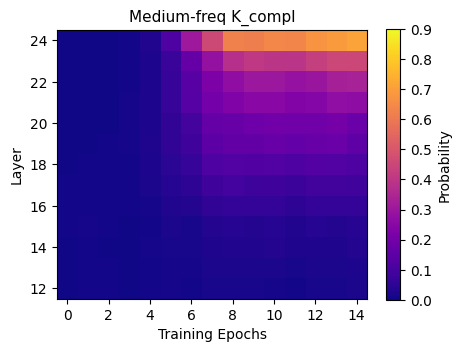

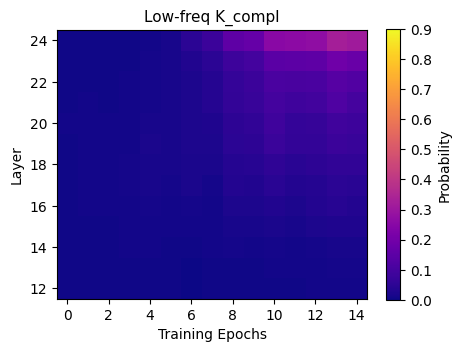

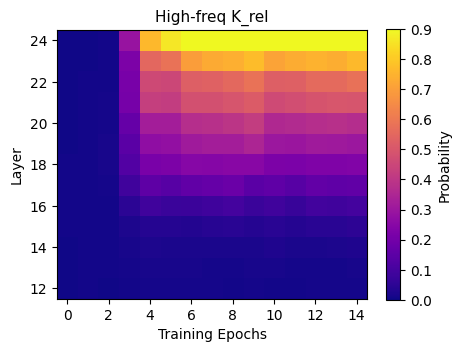

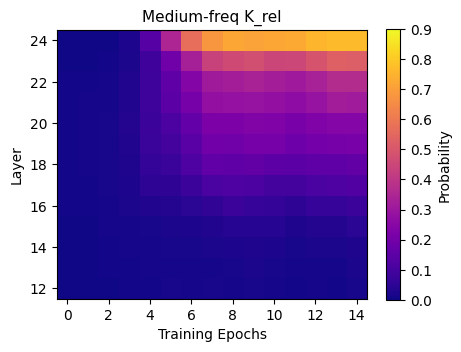

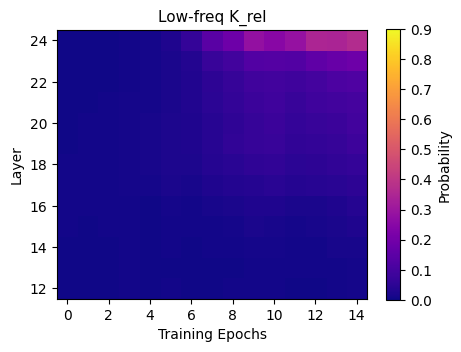

In [9]:
task = "city"
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        target_token_prob_matrix = []
        for item in target_token_prob[task][type][freq]:
            target_token_prob_matrix.append(item)
        target_token_prob_matrix = np.array(target_token_prob_matrix)

        half_index = target_token_prob_matrix.shape[1] // 2
        target_token_prob_matrix_half = target_token_prob_matrix[:, half_index:]
        # Set the figure size to increase x-axis width
        plt.figure(figsize=(5,4))  # Adjust width and height as needed

        im = plt.imshow(target_token_prob_matrix_half.T, cmap='plasma', interpolation='nearest',vmin=0, vmax=0.9)
        plt.title(f'{freq.capitalize()}-freq K_{k_type[type]}', fontsize=11)
        plt.ylabel('Layer')
        plt.xlabel('Training Epochs')
        plt.colorbar(shrink=0.88).set_label('Probability')
        # 反转 y 轴
        plt.gca().invert_yaxis()
        # 调整 yticks，仅显示后一半对应的范围
        num_layers = target_token_rank_at_last_matrix_half.shape[1]
        plt.yticks(
            np.arange(0, num_layers, 2),  # 每隔2个单位标一个刻度
            labels=np.arange(half_index, half_index + num_layers, 2)  # 标签对应原来的 layer 数值
        )
        plt.xticks(np.arange(0, target_token_rank_at_last_matrix_half.shape[0], 2))
        plt.show()

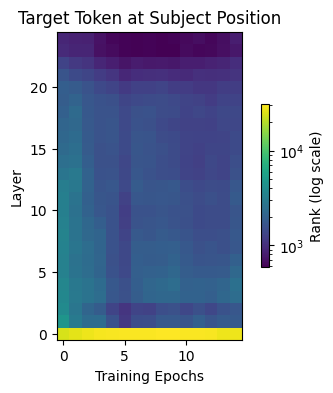

In [10]:
task = "city"
type = "new"
freq = "high"
target_token_rank_at_subject_matrix = []
for item in target_token_rank_at_subject[task][type][freq]:
    target_token_rank_at_subject_matrix.append(item.cpu().numpy())
target_token_rank_at_subject_matrix = np.array(target_token_rank_at_subject_matrix)
# Set the figure size to increase x-axis width
plt.figure(figsize=(5,4))  # Adjust width and height as needed

im = plt.imshow(target_token_rank_at_subject_matrix.T ,interpolation='nearest', norm=LogNorm(vmin=target_token_rank_at_subject_matrix.min(), vmax=target_token_rank_at_subject_matrix.max()))
plt.title(f'Target Token at Subject Position')
plt.ylabel('Layer')
plt.xlabel('Training Epochs')
plt.colorbar(shrink=0.53).set_label('Rank (log scale)')
# 反转 y 轴
plt.gca().invert_yaxis()
plt.show()